In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
import matplotlib.pylab as pylab
import cartopy.feature as cfeature
from endgame import hist2d
import scipy.stats as stats
import xarray as xr
import ipdb
import glob
import itertools
import numpy.ma as ma
from utils import u_statistics as u_stat
from scipy.stats import gaussian_kde
import pickle as pkl
from utils import u_plot as uplot, u_darrays as uda
import pandas as pd
import os
import xarray as xr

from utils import constants as cnst

pylab.rcParams['figure.figsize'] = (50., 50.)
%matplotlib inline

In [1]:
cd ..


/home/ck/pythonWorkspace/proj_CEH


Loads bulk statistics derived from having cut out storms (saved in MCSfiles), OBS includes rainfall from TRMM radar

In [3]:
cmip_path = '/media/ck/Elements/Africa/WestAfrica/CMIP6/'

In [4]:
def get_model_name(path):
    names = []
    files = glob.glob(path+'/*.nc')
    for f in files:
        fname = os.path.basename(f)
        #ipdb.set_trace()
        model = fname.split('_')[1]
        names.append(model)
    return names

In [5]:
shear_names = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear')

In [6]:
tcw_names = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw')

In [7]:
model_names_f = list(set(shear_names).intersection(set(tcw_names)))

In [8]:
len(model_names_f)

29

In [9]:
shear_names_h = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear')

In [10]:
tcw_names_h = get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw')

In [11]:
model_names_h = list(set(shear_names_h).intersection(set(tcw_names_h)))

In [12]:
model_names = list(set(model_names_h).intersection(set(model_names_f)))

In [13]:
len(model_names)

27

In [14]:
model_names

['NorESM2-LM',
 'GFDL-CM4',
 'NorESM2-MM',
 'CanESM5',
 'EC-Earth3-Veg',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'UKESM1-0-LL',
 'CAMS-CSM1-0',
 'CIESM',
 'BCC-CSM2-MR',
 'CMCC-CM2-SR5',
 'MIROC6',
 'CESM2-WACCM',
 'HadGEM3-GC31-MM',
 'INM-CM4-8',
 'FGOALS-g3',
 'KACE-1-0-G',
 'GFDL-ESM4',
 'CNRM-CM6-1',
 'MPI-ESM1-2-HR',
 'MIROC-ES2L',
 'CNRM-ESM2-1',
 'ACCESS-CM2',
 'MRI-ESM2-0',
 'AWI-CM-1-1-MR',
 'CNRM-CM6-1-HR']

In [19]:
get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr')

['INM-CM5-0',
 'ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'CanESM5',
 'CESM2-WACCM',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CNRM-CM6-1',
 'CNRM-ESM2-1',
 'EC-Earth3-CC',
 'EC-Earth3-Veg-LR',
 'EC-Earth3-Veg',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-CM4',
 'GFDL-ESM4',
 'IITM-ESM',
 'INM-CM4-8',
 'IPSL-CM6A-LR',
 'KACE-1-0-G',
 'MIROC6',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorESM2-LM',
 'NorESM2-MM',
 'TaiESM1',
 'UKESM1-0-LL']

In [20]:
get_model_name('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr_3h')

['BCC-CSM2-MR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'IPSL-CM6A-LR']

In [17]:

base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
shear_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/'
shear_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/'
tcw_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/'
tcw_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/'

lpaths = [('shear', shear_path_hist, shear_path_fut, 'ua'), ('tcw', tcw_path_hist, tcw_path_fut, 'prw')]

sahel = [-10,15,9,19]
x=2
y=1.1
ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W
bamako = [-8-x, -8+x, 12.6-y, 12.6+y]
dakar = [-16.9-x, -16.9+x, 14.8-y, 14.8+y]

pph = (1950,1999)

dnames = [('dakar', dakar),('sahel', sahel), ('ouaga',  ouaga), ('niamey', niamey), ('timbuktu',  timbuktu) ]
for regions in dnames:
    dic30 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    dic40 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    dic60 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    dic80 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    
    dics = [(dic30, '2020-2050'), (dic40, '2030-2060'), (dic60, '2050-2080') , (dic80, '2070-2100')]
    periods = [(2020, 2050, dic30, '2030', 1), (2030, 2060, dic40, '2040', 1), (2050,2080, dic60, '2060', 2), (2070,2100, dic80, '2080', 2)]
    for mn in model_names:

        print('Doing', mn)

        for pp in periods:
        
 
            hmask_dat = xr.open_dataset(glob.glob(tcw_path_fut+'*_'+mn+'_*.nc')[0]).load()

            try:
                hmask_dat =  (hmask_dat['prw'])[(hmask_dat['year']>=pp[0]) & (hmask_dat['year']<pp[1])].mean('year').squeeze()
            except:
                ipdb.set_trace()
            hmask = hmask_dat  #uda.shift_lons_data(

            for lids, l in enumerate(lpaths):
                print('Starting', l, mn)
                try:
                    hp = glob.glob(l[1]+'*_'+mn+'_*.nc')[0]
                    if lids == 0:
                        (pp[2])['model_name'].append(mn)
                except:
                    print('Model not found in historical, pass')
                    continue
                    
                fp = glob.glob(l[2]+'*_'+mn+'_*.nc')[0]
                hist = xr.open_dataset(hp)
                fut = xr.open_dataset(fp)

                var = l[3]

                if var not in fut.keys():
                    var = 'ua'
                try:
                    fut_diff =  (fut[var])[(fut['year']>=pp[0]) & (fut['year']<pp[1])].mean('year').squeeze()
                except:
                    ipdb.set_trace()
                    
                try:
                    hist_diff =  (hist[var])[(hist['year']>=pph[0]) & (hist['year']<pph[1])].mean('year').squeeze()
                except:
                    ipdb.set_trace()    

                diff = np.abs(fut_diff)-np.abs(hist_diff)
                if 0 in diff.shape:
                    hist_diff = fut_diff.salem.transform(hist_diff)
                    diff = np.abs(fut_diff)-np.abs(hist_diff)

                shift = diff

                hhist = hist_diff

                shift = shift.sel(lon=slice(-25,25), lat=slice(0,30))
                try:
                    hmask_on_dat = shift.salem.transform(hmask)
                except:
                    ipdb.set_trace()

                shift.values[(shift.values>500) | (shift.values<-500)]=np.nan
                hhist.values[(hhist.values>500) | (hhist.values<-500)]=np.nan
                
                if var == 'prw':
                    xx = (np.abs(shift)>pp[4])
                else:
                    xx = np.isfinite(shift)
                
                shift = shift.where((hmask_on_dat>=25) & xx)
                hhist = hhist.where(hmask_on_dat>=25) # 27.3 is 0.5th centile threshold for MCS distribution

                
                box = regions[1]
                (pp[2])[l[0]+'_mean'].append(np.float(shift.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean().squeeze().values))   # [-5,15,9,20], Central burkina faso: [-2.5,0,11,13.5]
                (pp[2])[l[0]+'_hist'].append(np.float(hhist.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean().squeeze().values))
              
                ltag = l[2].split('/')[-2]
                outp = fp.replace(ltag, l[0]+'_diff_'+pp[3])
                #ipdb.set_trace()
                da = xr.DataArray(shift.values[None,...],
                              coords={'model_name': np.array(mn)[None,...], 'lat': shift.lat,
                                      'lon': shift.lon},
                              dims=['model_name', 'lat', 'lon'])

                da.name = var

                da2 = xr.DataArray((hhist).values[None,...],
                  coords={'model_name': np.array(mn)[None,...], 'lat': shift.lat,
                          'lon': shift.lon},
                  dims=['model_name', 'lat', 'lon'])

                da2.name = var+'_hist'

                ds = xr.Dataset()
                ds[var] = da
                ds[var+'_hist'] = da2

    #             shift = shift.assign_attrs({'model_id':mn})
    #             shift = shift.assign_coords({'model_name' : mn})
    
                outp = outp.replace('/ssp585/', '/endgame/')
                try:
                    os.mkdir(os.path.dirname(outp))
                except:
                    pass
                if os.path.isfile(outp):
                    os.remove(outp)
                
                ds.to_netcdf(outp)
                print('Saving', outp)
    
    for dd in dics:
        #ipdb.set_trace()
        pd.DataFrame.from_dict(dd[0]).to_csv(base+ dd[1]+'_CMIP6_'+regions[0]+'.csv')

Doing UKESM1-0-LL
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') UKESM1-0-LL
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2030/CMIP6_UKESM1-0-LL_ssp585_mon_250 km_r1i1p1f2_2015-2100_925-600hPa_shear_diff_2030.nc
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') UKESM1-0-LL
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2030/CMIP6_UKESM1-0-LL_ssp585_mon_250 km_r1i1p1f2_2015-2100_tcw_diff_2030.nc
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') UKESM1-0-LL
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2040/CMIP6_UKESM1-0-LL_ssp585_mon_250 km_r1i1p1f2_2015-2100_925-600hPa_shear_diff_2040.nc
Starting ('tcw', '/media/ck/Elements/Afric

KeyboardInterrupt: 

In [ ]:
cmip6_hist = xr.open_dataset('/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/CMIP6_ACCESS-ESM1-5_historical_mon_250 km_r1i1p1f1_1850-2014_925-600hPa_shear.nc')

In [25]:
cmip6_fut = xr.open_dataset('/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/CMIP6_ACCESS-ESM1-5_ssp585_mon_250 km_r1i1p1f1_2015-2100_925-600hPa_shear.nc')

In [ ]:
cmip5_hist = xr.open_dataset('/media/ck/Elements/Africa/WestAfrica/CMIP5/historical/shear/CMIP6_ACCESS-ESM1-5_historical_mon_250 km_r1i1p1f1_1850-2014_925-600hPa_shear.nc')

In [ ]:
cmip5_fut = xr.open_dataset('/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/CMIP6_ACCESS-ESM1-5_historical_mon_250 km_r1i1p1f1_1850-2014_925-600hPa_shear.nc')

In [21]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
# pr_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP5/BC_CMIP5_0.5x0.5_rain/'
# pr_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP5/BC_CMIP5_0.5x0.5_rain/'

pr_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/'
pr_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/'

lpaths = [('pr', pr_hist, pr_fut, 'pr')]

sahel = [-10,15,9,19]
x=2
y=1.1
ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W
bamako = [-8-x, -8+x, 12.6-y, 12.6+y]
dakar = [-16.9-x, -16.9+x, 14.8-y, 14.8+y]

dnames = [('dakar', dakar) ] #('ouaga',  ouaga), ('niamey', niamey), ('timbuktu',  timbuktu), ('sahel', sahel), ('bamako', bamako)]   #('sahel', sahel)] #('ouaga',  ouaga), ('niamey', niamey), ('timbuktu',  timbuktu) ]   #('sahel', sahel),  ('bamako', bamako)
for regions in dnames:
    dic30 = {'model_name' : [], 'pr_mean' : [], 'pr_hist' : []}
    dic40 = {'model_name' : [], 'pr_mean' : [], 'pr_hist' : []}
    dic60 = {'model_name' : [], 'pr_mean' : [], 'pr_hist' : []}
    dic80 = {'model_name' : [], 'pr_mean' : [], 'pr_hist' : []}
    
    dics = [(dic80, '2070-2100')]  #(dic30, '2020-2050'), (dic40, '2030-2060'), (dic60, '2050-2080') , 
    periods = [(2070,2100, dic80, '2080', 2)]        #(2020, 2050, dic30, '2030', 1), (2030, 2060, dic40, '2040', 1), (2050,2080, dic60, '2060', 2), 
    for mn in model_names:

        print('Doing', mn)

        for pp in periods:

            

            for l in lpaths:
                print('Starting', l, mn)
                try:
                    hp = glob.glob(l[1]+'*_'+mn+'_historical_*.nc')[0]
                except:
                    print(l[1]+'*_'+mn+'_historical_*.nc')
                    print('Model not found, continue')
                    continue
                    
                
                try:
                    fp = glob.glob(l[2]+'*_'+mn+'_ssp585_*.nc')[0]
                except:
                    print('Future model not found, continue')
                    continue
                    
                (pp[2])['model_name'].append(mn)
                hist = xr.open_dataset(hp)
                fut = xr.open_dataset(fp)

                var = l[3]
                try:
                    diff = fut['pr']-hist['pr']
                except:
                    ipdb.set_trace()

                shift = diff# uda.shift_lons_data(diff)

                hhist = hist['pr'] #uda.shift_lons_data(hist[var])
               # ipdb.set_trace()
                shift.values[(shift.values>500.) | (shift.values<-500.)]=np.nan
                hhist.values[(hhist.values>500.) | (hhist.values<-500.)]=np.nan
                
                box = regions[1]
                (pp[2])[l[0]+'_mean'].append(np.float(shift.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean().squeeze().values))   # [-5,15,9,20], Central burkina faso: [-2.5,0,11,13.5]
                (pp[2])[l[0]+'_hist'].append(np.float(hhist.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean().squeeze().values))
                ltag = l[2].split('/')[-2]
                outp = fp.replace(ltag, l[0]+'_diff_'+pp[3])
                #ipdb.set_trace()
                outp = outp.replace('/CMIP6/ssp585/', '/CMIP6/endgame/')
                #ipdb.set_trace()
                da = xr.DataArray(shift.values[None,...],
                              coords={'model_name': np.array(mn)[None,...], 'lat': shift.lat,
                                      'lon': shift.lon},
                              dims=['model_name', 'lat', 'lon'])

                da.name = var

                da2 = xr.DataArray((hhist).values[None,...],
                  coords={'model_name': np.array(mn)[None,...], 'lat': shift.lat,
                          'lon': shift.lon},
                  dims=['model_name', 'lat', 'lon'])

                da2.name = var+'_hist'

                ds = xr.Dataset()
                ds[var] = da
                ds[var+'_hist'] = da2

    #             shift = shift.assign_attrs({'model_id':mn})
    #             shift = shift.assign_coords({'model_name' : mn})
                print('OUTP', outp)
                if os.path.isfile(outp):
                    os.remove(outp)

                ds.to_netcdf(outp)
                #ipdb.set_trace()
                print('Saving', outp)
    #ipdb.set_trace()
    for dd in dics:
        pd.DataFrame.from_dict(dd[0]).to_csv(base+ dd[1]+'_RAW_CMIP6_'+regions[0]+'.csv')
        print('Written DIR!')

Doing NorESM2-LM
Starting ('pr', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/', 'pr') NorESM2-LM
OUTP /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_NorESM2-LM_ssp585_day_250 km_r1i1p1f1_2015-2100_pr_diff_2080.nc
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_NorESM2-LM_ssp585_day_250 km_r1i1p1f1_2015-2100_pr_diff_2080.nc
Doing KACE-1-0-G
Starting ('pr', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/', 'pr') KACE-1-0-G
OUTP /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_KACE-1-0-G_ssp585_day_250 km_r1i1p1f1_2015-2100_pr_diff_2080.nc
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_KACE-1-0-G_ssp585_day_250 km_r1i1p1f1_2015-2100_pr_diff_2080.nc
Doing AWI-CM-1-1-MR
Starting ('pr', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/', '/media

OUTP /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_UKESM1-0-LL_ssp585_day_250 km_r1i1p1f2_2015-2100_pr_diff_2080.nc
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_UKESM1-0-LL_ssp585_day_250 km_r1i1p1f2_2015-2100_pr_diff_2080.nc
Doing ACCESS-CM2
Starting ('pr', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/', 'pr') ACCESS-CM2
OUTP /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_ACCESS-CM2_ssp585_day_250 km_r1i1p1f1_2015-2100_pr_diff_2080.nc
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_ACCESS-CM2_ssp585_day_250 km_r1i1p1f1_2015-2100_pr_diff_2080.nc
Doing CanESM5
Starting ('pr', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/', 'pr') CanESM5
OUTP /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/pr_diff_2080/CMIP6_CanESM5_ssp585_day_500 km_r1i1p1f

In [33]:

base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
shear_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/'
shear_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/'
tcw_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/'
tcw_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/'

lpaths = [('shear', shear_path_hist, shear_path_fut, 'ua'), ('tcw', tcw_path_hist, tcw_path_fut, 'prw')]

sahel = [-10,15,9,19]
x=2
y=1.1
ouaga=[-1.52-x,-1.52+x,12.38-y,12.38+y]  #12.3714° N, 1.5197° W
niamey = [2.13-x,2.13+x, 13.51-y,13.51+y] #13.5116° N, 2.1254° E
timbuktu = [ -3-x,-3+x, 16.77-y,16.77+y] #16.7666° N, 3.0026° W
bamako = [-8-x, -8+x, 12.6-y, 12.6+y]
dakar = [-16.9-x, -16.9+x, 14.8-y, 14.8+y]

pph = (1997,2006)

dnames = [('sahel', sahel)]#('sahel', sahel), ('ouaga',  ouaga), ('niamey', niamey), ('timbuktu',  timbuktu) ]
for regions in dnames:
    dic30 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    dic40 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    dic60 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    dic80 = {'model_name' : [], 'shear_mean' : [], 'tcw_mean' : [], 'tcw_hist' : [], 'shear_hist' : []}
    
    dics = [(dic30, '2020-2050'), (dic40, '2030-2060'), (dic60, '2050-2080') , (dic80, '2070-2100')]
    periods = [(2020, 2050, dic30, '2030', 1), (2030, 2060, dic40, '2040', 1), (2050,2080, dic60, '2060', 2), (2070,2100, dic80, '2080', 2)]
    for mn in model_names:

        print('Doing', mn)

        for pp in periods:
        
 
            hmask_dat = xr.open_dataset(glob.glob(tcw_path_fut+'*_'+mn+'_*.nc')[0]).load()

            try:
                hmask_dat =  (hmask_dat['prw'])[(hmask_dat['year']>=pp[0]) & (hmask_dat['year']<pp[1])].mean('year').squeeze()
            except:
                ipdb.set_trace()
            hmask = hmask_dat  #uda.shift_lons_data(

            for lids, l in enumerate(lpaths):
                print('Starting', l, mn)
                try:
                    hp = glob.glob(l[1]+'*_'+mn+'_*.nc')[0]
                    if lids == 0:
                        (pp[2])['model_name'].append(mn)
                except:
                    print('Model not found in historical, pass')
                    continue
                    
                fp = glob.glob(l[2]+'*_'+mn+'_*.nc')[0]
                hist = xr.open_dataset(hp)
                fut = xr.open_dataset(fp)

                var = l[3]

                if var not in fut.keys():
                    var = 'ua'
                try:
                    fut_diff =  (fut[var])[(fut['year']>=pp[0]) & (fut['year']<pp[1])].mean('year').squeeze()
                except:
                    ipdb.set_trace()
                    
                try:
                    hist_diff =  (hist[var])[(hist['year']>=pph[0]) & (hist['year']<pph[1])].mean('year').squeeze()
                except:
                    ipdb.set_trace()    

                diff = np.abs(fut_diff)-np.abs(hist_diff)
                if 0 in diff.shape:
                    hist_diff = fut_diff.salem.transform(hist_diff)
                    diff = np.abs(fut_diff)-np.abs(hist_diff)

                shift = diff

                hhist = hist_diff

                shift = shift.sel(lon=slice(-25,25), lat=slice(0,30))
                try:
                    hmask_on_dat = shift.salem.transform(hmask)
                except:
                    ipdb.set_trace()

                shift.values[(shift.values>500) | (shift.values<-500)]=np.nan
                hhist.values[(hhist.values>500) | (hhist.values<-500)]=np.nan
                
                if var == 'prw':
                    xx = (np.abs(shift)>pp[4])
                else:
                    xx = np.isfinite(shift)
                
                shift = shift.where((hmask_on_dat>=25) & xx)
                hhist = hhist.where(hmask_on_dat>=25) # 27.3 is 0.5th centile threshold for MCS distribution

                
                box = regions[1]
                (pp[2])[l[0]+'_mean'].append(np.float(shift.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean().squeeze().values))   # [-5,15,9,20], Central burkina faso: [-2.5,0,11,13.5]
                (pp[2])[l[0]+'_hist'].append(np.float(hhist.sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3])).mean().squeeze().values))
              
                ltag = l[2].split('/')[-2]
                outp = fp.replace(ltag, l[0]+'_diff_'+pp[3])
                #ipdb.set_trace()
                da = xr.DataArray(shift.values[None,...],
                              coords={'model_name': np.array(mn)[None,...], 'lat': shift.lat,
                                      'lon': shift.lon},
                              dims=['model_name', 'lat', 'lon'])

                da.name = var

                da2 = xr.DataArray((hhist).values[None,...],
                  coords={'model_name': np.array(mn)[None,...], 'lat': shift.lat,
                          'lon': shift.lon},
                  dims=['model_name', 'lat', 'lon'])

                da2.name = var+'_hist'

                ds = xr.Dataset()
                ds[var] = da
                ds[var+'_hist'] = da2

    #             shift = shift.assign_attrs({'model_id':mn})
    #             shift = shift.assign_coords({'model_name' : mn})
    
                outp = outp.replace('/ssp585/', '/endgame/')
#                 try:
#                     os.mkdir(os.path.dirname(outp))
#                 except:
#                     pass
#                 if os.path.isfile(outp):
#                     os.remove(outp)
                
#                 ds.to_netcdf(outp)
#                 print('Saving', outp)
    
    for dd in dics:
        #ipdb.set_trace()
        pd.DataFrame.from_dict(dd[0]).to_csv(base+ dd[1]+'_CMIP6_1997HIST'+regions[0]+'.csv')

Doing UKESM1-0-LL
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') UKESM1-0-LL
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') UKESM1-0-LL
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') UKESM1-0-LL
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') UKESM1-0-LL
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') UKESM1-0-LL
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') UKESM1-0-LL
Starting ('shear', '/media/ck/E

Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') CESM2-WACCM
Doing ACCESS-CM2
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') ACCESS-CM2
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') ACCESS-CM2
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') ACCESS-CM2
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') ACCESS-CM2
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') ACCESS-CM2
Starting ('tcw', '/media/ck/Elements/

Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') HadGEM3-GC31-MM
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') HadGEM3-GC31-MM
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') HadGEM3-GC31-MM
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') HadGEM3-GC31-MM
Doing NorESM2-MM
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') NorESM2-MM
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') NorESM2-MM
Starting ('shear',

Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') INM-CM4-8
Doing EC-Earth3-Veg
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') EC-Earth3-Veg
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') EC-Earth3-Veg
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') EC-Earth3-Veg
Starting ('tcw', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/', 'prw') EC-Earth3-Veg
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') EC-Earth3-Veg
Starting ('tcw', '/me

In [34]:
def prep_cmip_list(region):
    base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
    dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
    cmip5_read = {}
    cmip_read = {}
    for dd in dics:
        cmip5_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP6_1997HIST'+region+'.csv', index_col='model_name')
        cmip5_read[dd[1]] = cmip5_read[dd[1]].dropna()
        
    base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
    dics = [('2020-2050', '2030'), ('2030-2060', '2040'), ('2050-2080', '2060'), ('2070-2100', '2080')]
    cmip6_read = {}
    for dd in dics:
        cmip6_read[dd[1]] = pd.read_csv(base+dd[0]+'_CMIP6_'+region+'.csv', index_col='model_name')
        cmip6_read[dd[1]] = cmip6_read[dd[1]].dropna()

    
    return cmip5_read, cmip6_read

In [35]:
t1997, t1950 = prep_cmip_list('sahel')

In [36]:
t1997 = t1997['2080']
t1950 = t1950['2080']

In [37]:
tcw_diff = (t1997['tcw_hist']-t1950['tcw_hist'])

In [38]:
bla = np.mean(tcw_diff)
perc = np.percentile(tcw_diff, [10,90])
print(np.mean(tcw_diff))

2.3904687441312347


In [25]:
perc

array([1.79546547, 3.23036385])

In [39]:
shear_diff = (t1997['shear_hist']-t1950['shear_hist'])

In [40]:
bla = np.mean(shear_diff)
perc = np.percentile(shear_diff, [10,90])
print(np.mean(shear_diff))

0.5364203086266152


In [41]:
perc

array([-0.01887941,  1.00197649])

In [42]:
2.39*1.2+0.5*0.79

3.263

In [ ]:
#TIMESERIES

In [85]:
base = '/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/'
shear_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/'
shear_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/'
tcw_path_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/prw/'
tcw_path_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/prw/'
pr_hist = '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/pr/'
pr_fut = '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/pr/'

lpaths = [('shear', shear_path_hist, shear_path_fut, 'ua')] #[('tcw', tcw_path_hist, tcw_path_fut, 'prw')]   #('shear', shear_path_hist, shear_path_fut, 'ua'), 

sahel = [-5,7.5,10,15]
wsahel = [-17.5,-5,10,15]

pph = (1850,2016)

dnames = [('sahel', sahel), ('wsahel', wsahel)]#('sahel', sahel), ('ouaga',  ouaga), ('niamey', niamey), ('timbuktu',  timbuktu) ]
for regions in dnames:

    periods = [(2015,2100, '', '2010', 2)]
    box = regions[1]
    for mn in model_names:

        print('Doing', mn)

        for pp in periods:
        
 
#             hmask_dat = xr.open_dataset(glob.glob(tcw_path_fut+'*_'+mn+'_*.nc')[0]).load()

#             try:
#                 hmask_dat =  (hmask_dat['prw'])[(hmask_dat['year']>=pp[0]) & (hmask_dat['year']<pp[1])].mean(['lat', 'lon']).squeeze()
#             except:
#                 ipdb.set_trace()
#             hmask = hmask_dat  #uda.shift_lons_data(

            for lids, l in enumerate(lpaths):
                print('Starting', l, mn)
                try:
                    hp = glob.glob(l[1]+'*_'+mn+'_*.nc')[0]

                except:
                    print('Model not found in historical, pass')
                    continue
                    
                fp = glob.glob(l[2]+'*_'+mn+'_*.nc')[0]
                try:
                    hist = xr.open_dataset(hp).sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))
                except:
                    ipdb.set_trace()
                fut = xr.open_dataset(fp).sel(lon=slice(box[0],box[1]), lat=slice(box[2],box[3]))

                var = l[3]

                if var not in fut.keys():
                    var = 'ua'
                try:
                    fut_diff =  (fut[var])[(fut['year']>=pp[0]) & (fut['year']<pp[1])].mean(['lat','lon']).squeeze()
                except:
                    ipdb.set_trace()
                    
                try:
                    hist_diff =  (hist[var])[(hist['year']>=pph[0]) & (hist['year']<pph[1])].mean(['lat', 'lon']).squeeze()
                except:
                    ipdb.set_trace()    

                diff = np.abs(fut_diff)-np.abs(hist_diff.mean('year'))
                if 0 in diff.shape:
                    histd = fut_diff.salem.transform(hist_diff.mean('year'))
                    diff = np.abs(fut_diff)-np.abs(histd)

                shift = diff

                hhist = hist_diff

                shift.values[(shift.values>500) | (shift.values<-500)]=np.nan
                hhist.values[(hhist.values>500) | (hhist.values<-500)]=np.nan
             
              
                ltag = l[2].split('/')[-2]
                outp = fp.replace(ltag, l[0]+'_diff_2020-2100_'+regions[0]+'_'+pp[3])
                #ipdb.set_trace()
                da = xr.DataArray(shift.values[None,...],
                              coords={'model_name': np.array(mn)[None,...], 'year': shift.year.values},
                              dims=['model_name', 'year'])

                da.name = var

                da2 = xr.DataArray((hhist).values[None,...],
                  coords={'model_name': np.array(mn)[None,...], 'hyear':hhist.year.values},
                  dims=['model_name', 'hyear'])

                da2.name = var+'_hist'

                ds = xr.Dataset()
                ds[var] = da
                ds[var+'_hist'] = da2
    
                outp = outp.replace('/ssp585/', '/endgame/')
                try:
                    os.mkdir(os.path.dirname(outp))
                except:
                    pass
                if os.path.isfile(outp):
                    os.remove(outp)

                ds.to_netcdf(outp)
                print('Saving', outp)
                
            

Doing NorESM2-LM
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') NorESM2-LM
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2020-2100_sahel_2010/CMIP6_NorESM2-LM_ssp585_mon_250 km_r1i1p1f1_2015-2100_925-600hPa_shear_diff_2020-2100_sahel_2010.nc
Doing GFDL-CM4
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') GFDL-CM4
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2020-2100_sahel_2010/CMIP6_GFDL-CM4_ssp585_monC_100 km_r1i1p1f1_2015-2100_925-600hPa_shear_diff_2020-2100_sahel_2010.nc
Doing NorESM2-MM
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') NorESM2-MM
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2020-2100_sahel_2010/CMIP

Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2020-2100_sahel_2010/CMIP6_ACCESS-CM2_ssp585_mon_250 km_r1i1p1f1_2015-2100_925-600hPa_shear_diff_2020-2100_sahel_2010.nc
Doing MRI-ESM2-0
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') MRI-ESM2-0
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2020-2100_sahel_2010/CMIP6_MRI-ESM2-0_ssp585_mon_100 km_r1i1p1f1_2015-2100_925-600hPa_shear_diff_2020-2100_sahel_2010.nc
Doing AWI-CM-1-1-MR
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') AWI-CM-1-1-MR
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2020-2100_sahel_2010/CMIP6_AWI-CM-1-1-MR_ssp585_mon_100 km_r1i1p1f1_2015-2100_925-600hPa_shear_diff_2020-2100_sahel_2010.nc
Doing CNRM-CM6-1-HR
Starting ('shear', '/media/ck/Elements/Africa/W

Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2020-2100_wsahel_2010/CMIP6_MPI-ESM1-2-HR_ssp585_mon_100 km_r1i1p1f1_2015-2100_925-600hPa_shear_diff_2020-2100_wsahel_2010.nc
Doing MIROC-ES2L
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') MIROC-ES2L
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2020-2100_wsahel_2010/CMIP6_MIROC-ES2L_ssp585_mon_500 km_r1i1p1f2_2015-2100_925-600hPa_shear_diff_2020-2100_wsahel_2010.nc
Doing CNRM-ESM2-1
Starting ('shear', '/media/ck/Elements/Africa/WestAfrica/CMIP6/historical/shear/', '/media/ck/Elements/Africa/WestAfrica/CMIP6/ssp585/shear/', 'ua') CNRM-ESM2-1
Saving /media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2020-2100_wsahel_2010/CMIP6_CNRM-ESM2-1_ssp585_mon_250 km_r1i1p1f2_2015-2100_925-600hPa_shear_diff_2020-2100_wsahel_2010.nc
Doing ACCESS-CM2
Starting ('shear', '/media/ck/Elements/Africa/W

In [86]:
model_names

['NorESM2-LM',
 'GFDL-CM4',
 'NorESM2-MM',
 'CanESM5',
 'EC-Earth3-Veg',
 'HadGEM3-GC31-LL',
 'IPSL-CM6A-LR',
 'UKESM1-0-LL',
 'CAMS-CSM1-0',
 'CIESM',
 'BCC-CSM2-MR',
 'CMCC-CM2-SR5',
 'MIROC6',
 'CESM2-WACCM',
 'HadGEM3-GC31-MM',
 'INM-CM4-8',
 'FGOALS-g3',
 'KACE-1-0-G',
 'GFDL-ESM4',
 'CNRM-CM6-1',
 'MPI-ESM1-2-HR',
 'MIROC-ES2L',
 'CNRM-ESM2-1',
 'ACCESS-CM2',
 'MRI-ESM2-0',
 'AWI-CM-1-1-MR',
 'CNRM-CM6-1-HR']

In [87]:
g6_subgroup = ['ACCESS-CM2', 'CESM2-WACCM', 'CNRM-CM6-1', 'INM-CM4-8', 'IPSL-CM6A-LR', 'MIROC6', 'MPI-ESM1-2-HR', 'UKESM1-0-LL']

In [153]:

def run(dom, subgroup):
    models = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/tcw_diff_2020-2100_'+dom+'_2010/*.nc', concat_dim='model_name')

    models = models.where((models.model_name!='CMCC-CM2-SR5'), drop=True)
  #  ipdb.set_trace()
    past = models['prw_hist'].load()-models['prw_hist'].mean('hyear')
    fut = models['prw'].isel(hyear=1).load()
    
    submodels = []
    for g6 in subgroup:
        try:
            isthere = models.sel(model_name=g6)
            submodels.append(isthere)
        except:
            continue
    
    submodels = xr.concat(submodels, dim='model_name')
    
    subpast = submodels['prw_hist'].load()-submodels['prw_hist'].mean('hyear')
    subfut = submodels['prw'].isel(hyear=1).load()
    
    return past, fut, subpast, subfut

In [154]:

# def run(dom, subgroup):
#     models = xr.open_mfdataset('/media/ck/Elements/Africa/WestAfrica/CMIP6/endgame/shear_diff_2020-2100_'+dom+'_2010/*.nc', concat_dim='model_name')
#     past = models['ua_hist'].load()-models['ua_hist'].mean('hyear')
#     fut = models['ua'].isel(hyear=1).load()
    
#     submodels = []
#     for g6 in subgroup:
#         try:
#             isthere = models.sel(model_name=g6)
#             submodels.append(isthere)
#         except:
#             continue
    
#     submodels = xr.concat(submodels, dim='model_name')
    
#     subpast = submodels['ua_hist'].load()-submodels['ua_hist'].mean('hyear')
#     subfut = submodels['ua'].isel(hyear=1).load()
    
#     return past, fut, subpast, subfut

In [155]:
dom='wsahel'
wpast, wfut, wgpast, wgfut = run(dom, g6_subgroup)

/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/ck/miniconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


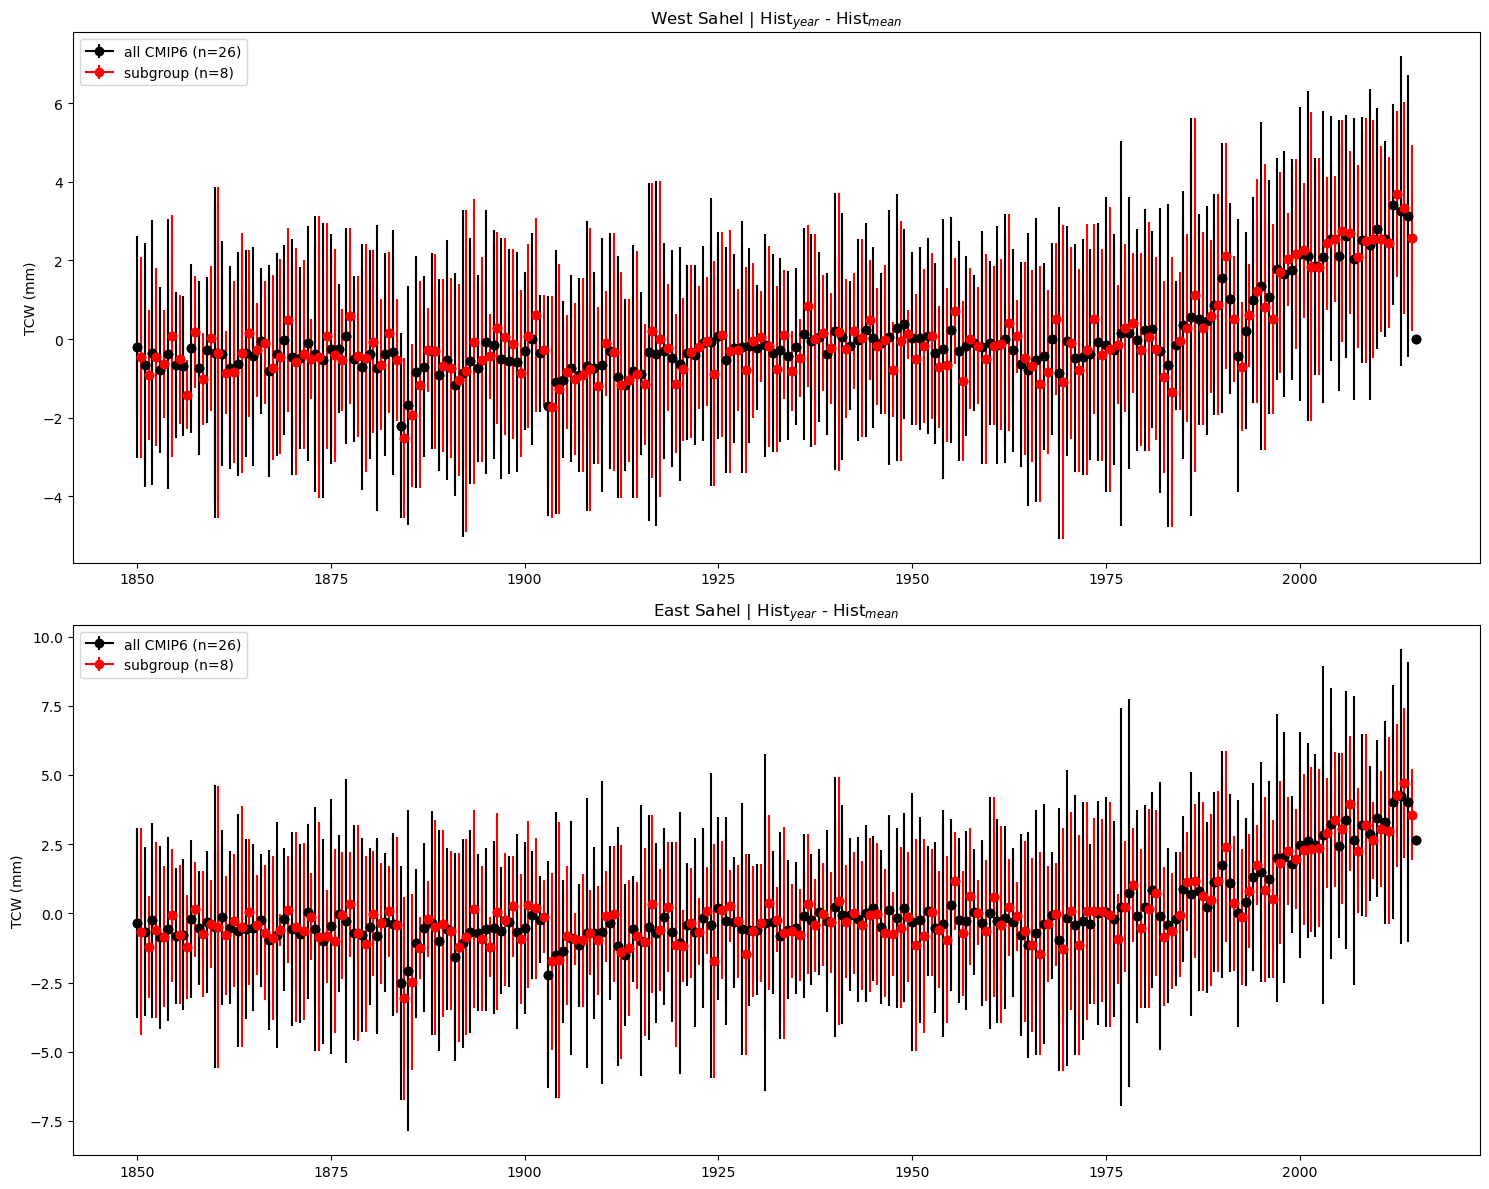

In [176]:
f = plt.figure(figsize=(15,12), dpi=100)
ax = f.add_subplot(211)
dom='wsahel'
wpast, wfut, wgpast, wgfut = run(dom, g6_subgroup)
for ids, pp in enumerate(wpast.hyear):
    dat = wpast.sel(hyear=pp)
    if ids == 0:
        plt.errorbar([dat.hyear]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o', label='all CMIP6 (n=26)')
    else:
        plt.errorbar([dat.hyear]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o')
        

for ids, pp in enumerate(wgpast.hyear):
    try:
        dat = wgpast.sel(hyear=pp)
    except:
        continue
    if ids == 0:
        plt.errorbar(np.array([dat.hyear]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o', label='subgroup (n=8)')
    else:
        plt.errorbar(np.array([dat.hyear]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o')

        
plt.title('West Sahel | Hist$_{year}$ - Hist$_{mean}$')    
plt.legend(loc='upper left')
plt.ylabel('TCW (mm)')
        
ax = f.add_subplot(212)
dom='sahel'
wpast, wfut, wgpast, wgfut = run(dom, g6_subgroup)
for ids, pp in enumerate(wpast.hyear):
    dat = wpast.sel(hyear=pp)
    if ids == 0:
        plt.errorbar([dat.hyear]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o', label='all CMIP6 (n=26)')
    else:
        plt.errorbar([dat.hyear]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o')
        

for ids, pp in enumerate(wgpast.hyear):
    try:
        dat = wgpast.sel(hyear=pp)
    except:
        continue
    if ids == 0:
        plt.errorbar(np.array([dat.hyear]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o', label='subgroup (n=8)')
    else:
        plt.errorbar(np.array([dat.hyear]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o')

        
plt.title('East Sahel | Hist$_{year}$ - Hist$_{mean}$')    
plt.legend(loc='upper left')
plt.ylabel('TCW (mm)')
plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/cmip6_TCW_minmax_historical.jpg')

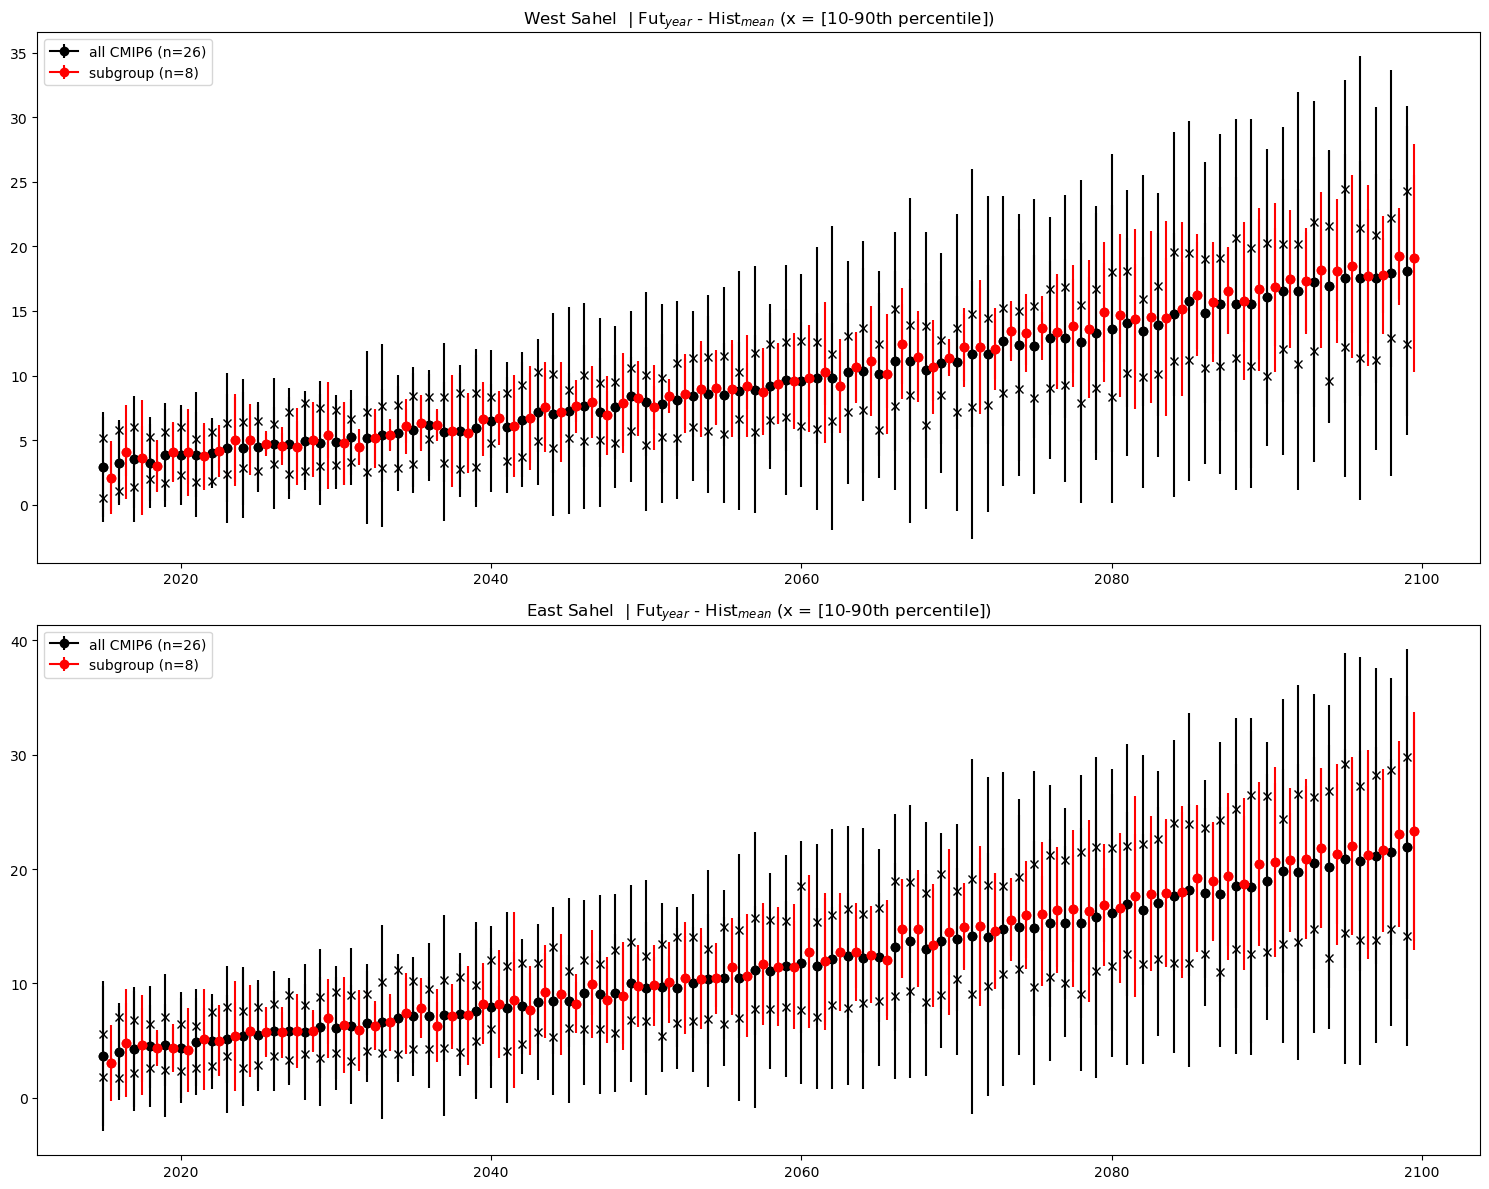

In [177]:
f = plt.figure(figsize=(15,12), dpi=100)
ax = f.add_subplot(211)
dom='wsahel'
wpast, wfut, wgpast, wgfut = run(dom, g6_subgroup)
for ids, pp in enumerate(wfut.year):
    dat = wfut.sel(year=pp)
    if ids == 0:
        plt.errorbar([dat.year]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o', label='all CMIP6 (n=26)')
    else:
        plt.errorbar([dat.year]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o')
        
    plt.plot(dat.year, np.percentile(dat,90), marker='x', color='k')
    plt.plot(dat.year, np.percentile(dat,10), marker='x', color='k')
        

for ids, pp in enumerate(wgfut.year):
    try:
        dat = wgfut.sel(year=pp)
    except:
        continue
    if ids == 0:
        plt.errorbar(np.array([dat.year]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o', label='subgroup (n=8)')
    else:
        plt.errorbar(np.array([dat.year]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o')

        
plt.title('West Sahel  | Fut$_{year}$ - Hist$_{mean}$ (x = [10-90th percentile])')    
plt.legend(loc='upper left')
        
ax = f.add_subplot(212)
dom='sahel'
wpast, wfut, wgpast, wgfut = run(dom, g6_subgroup)
for ids, pp in enumerate(wfut.year):
    dat = wfut.sel(year=pp)
    if ids == 0:
        plt.errorbar([dat.year]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o', label='all CMIP6 (n=26)')
    else:
        plt.errorbar([dat.year]*2,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='k', marker='o')
        
        
    plt.plot(dat.year, np.percentile(dat,90), marker='x', color='k')
    plt.plot(dat.year, np.percentile(dat,10), marker='x', color='k')

for ids, pp in enumerate(wgfut.year):
    try:
        dat = wgfut.sel(year=pp)
    except:
        continue
    if ids == 0:
        plt.errorbar(np.array([dat.year]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o', label='subgroup (n=8)')
    else:
        plt.errorbar(np.array([dat.year]*2)+0.5,[np.mean(dat)]*2, yerr=[np.array(np.mean(dat)-np.min(dat)), np.array(np.max(dat)-np.mean(dat))], color='r', marker='o')

        
plt.title('East Sahel  | Fut$_{year}$ - Hist$_{mean}$ (x = [10-90th percentile])')    
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('/home/ck/DIR/cornkle/figs/ENDGAME/cmip6_TCW_minmax_future.jpg')

ACCESS-CM2 1228.2396
AWI-CM-1-1-MR 1120.5859
BCC-CSM2-MR 743.04517
CAMS-CSM1-0 526.301
CESM2-WACCM 1055.3446
CIESM 764.6651
CNRM-CM6-1 965.1349
CNRM-CM6-1-HR 947.13513
CNRM-ESM2-1 941.7019
CanESM5 1808.7152
EC-Earth3-Veg 1450.0762
FGOALS-g3 704.84314
GFDL-CM4 849.2092
GFDL-ESM4 609.9442
HadGEM3-GC31-LL 1200.1581
HadGEM3-GC31-MM 1075.583
INM-CM4-8 729.88184
IPSL-CM6A-LR 1350.7625
KACE-1-0-G 1012.4602
MIROC-ES2L 847.7106
MIROC6 713.1241
MPI-ESM1-2-HR 925.966
MRI-ESM2-0 979.64087
NorESM2-LM 970.2645
NorESM2-MM 890.73926
UKESM1-0-LL 1305.3842


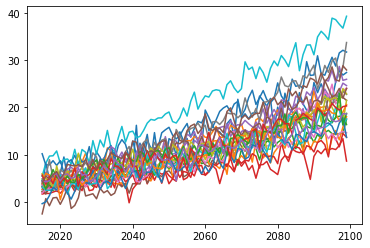

In [158]:
for pp in wfut:
    plt.plot(pp.year, pp)
    print(pp.model_name.values, np.sum(pp.values))